<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setup

In [0]:
from PIL import Image
from io import BytesIO
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn,optim
import requests
from torchvision import transforms,models

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2 使用VGG19作特征提取器

In [7]:
vgg=models.vgg19(pretrained=True).features
for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [8]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 3 数据

In [0]:
def load_image(img_path,max_size=400,shape=None):
  if 'http' in img_path:
    response=requests.get(img_path)
    image=Image.open(BytesIO(response.content)).convert('RGB')
  else:
    image=Image.open(img_path).convert('RGB')
  if max(image.size)>max_size:
    size=max_size
  else:
    size=max(image.size)
  if shape is not None:
    size=shape
  in_transform=transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
               (0.229,0.224,0.225))
  ])
  image=in_transform(image)[:3,:,:].unsqueeze(0)
  return image

In [0]:
ROOT='./gdrive/My Drive/Colab Notebooks/udacity/images'

In [0]:
content=load_image(os.path.join(ROOT,'octopus.jpg')).to(device)
style=load_image(os.path.join(ROOT,'hockney.jpg'),shape=content.shape[-2:]).to(device)

In [0]:
def im_convert(tensor):
  image=tensor.to('cpu').clone().detach().numpy().squeeze()
  image=image.transpose(1,2,0)
  image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
  image=image.clip(0,1)
  return image

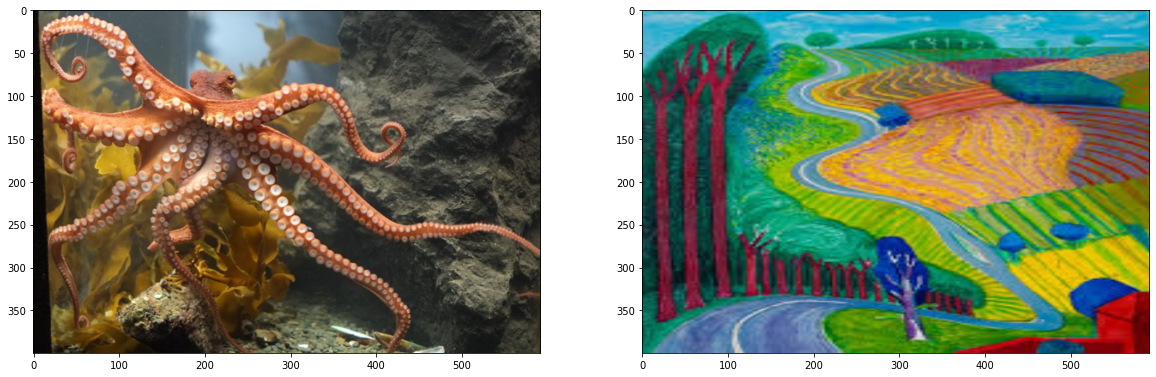

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# 4 提取内容图像和风格图像的特征

In [0]:
print(vgg)

In [14]:
vgg[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [0]:
def get_features(image,model,layers=None):
  if layers is None:
    layers={'0':'conv1_1',
        '5':'conv2_1',
        '10':'conv3_1',
        '19':'conv4_1',
        '21':'conv4_2',
        '28':'conv5_1'}

  features={}
  x=image
  for name,layer in model._modules.items():
    x=layer(x)
    if name in layers:
      features[layers[name]]=x
  return features

In [0]:
# Gram Matrix
def gram_matrix(tensor):
  _,c,h,w=tensor.shape
  tensor=tensor.view(c,h*w)
  gram=torch.mm(tensor,tensor.t())
  return gram

In [17]:
a=np.random.randn(1,3,6,7)
a=torch.from_numpy(a)
_,c,h,w=a.shape
a=a.view(c,h*w)
a.shape

torch.Size([3, 42])

In [0]:
content_features=get_features(content,vgg)
style_features=get_features(style,vgg)

style_grams={layer:gram_matrix(style_features[layer]) for layer in style_features}
target=content.clone().requires_grad_(True).to(device)

# 5 损失函数及训练

In [0]:
style_weights={'conv1_1':1.,
        'conv2_1':0.75,
        'conv3_1':0.2,
        'conv4_1':0.2,
        'conv5_1':0.2}
content_weight=1
style_weight=1e6

total loss: 49119580.0
total loss: 9949606.0
total loss: 5176580.5
total loss: 3145422.5
total loss: 2024151.0


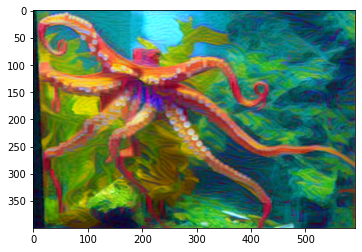

In [25]:
show_every=400
optimizer=optim.Adam([target],lr=0.003)
steps=2000
for ii in range(1,steps+1):
  target_features=get_features(target,vgg)
  content_loss=torch.mean((target_features['conv4_2']-content_features['conv4_2'])**2)
  style_loss=0
  for layer in style_weights:
    target_feature=target_features[layer]
    _,d,h,w=target_feature.shape
    target_gram=gram_matrix(target_feature)
    style_gram=style_grams[layer]
    layer_style_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    style_loss+=layer_style_loss/(d*h*w)
  total_loss=content_weight*content_loss+style_weight*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  if ii%show_every==0:
    print('total loss:',total_loss.item())
    plt.imshow(im_convert(target))
    plt.imshow()

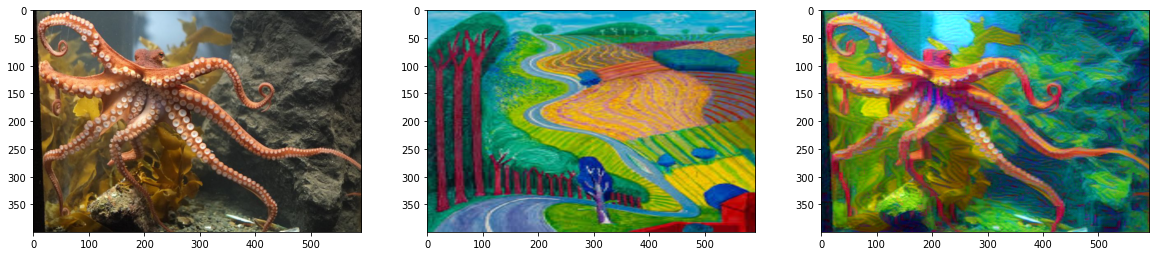

In [26]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))